# Locking-free Reissner-Mindlin plate with Crouzeix-Raviart interpolation

This tour explores a new discretization strategy for Reissner-Mindlin plates. It is known that such thick plate discretizations face the shear-locking issue in the thin plate limit. Different strategies can be adopted to alleviate this issue such as:

* reduced integration (see [Reissner-Mindlin plate with Quadrilaterals](https://comet-fenics.readthedocs.io/en/latest/demo/reissner_mindlin_quads_reduced_integration/reissner_mindlin_quads.py.html))
* Discontinuous Galerkin methods (see [Reissner-Mindlin plate with a Discontinuous-Galerkin approach](https://comet-fenics.readthedocs.io/en/latest/demo/reissner_mindlin_discontinuous_galerkin/reissner_mindlin_dg.py.html))
* mixed methods (see the `fenics-shells` [demo using the Duran-Liberman element](https://fenics-shells.readthedocs.io/en/latest/demo/reissner-mindlin-clamped/demo_reissner-mindlin-clamped.py.html))
* and many more...

Often such methods can be quite cumbersome to implement, even more with FEniCS. In this tour, we investigate another discretization which does not seem to have been widely studied in the literature, except in [[CAM03]](#References) and subsequent works from the same group of authors where it has been used for a shell element. Note that Crouzeix-Raviart elements have already been used in Reissner-Mindlin plate models such as in [[ARN89]](#References) but with a different discretization strategy than the present one.

The discretization that we will explore is extremely simple:

* $P^2$ Lagrange continuous interpolation for the plate deflection $w$
* Crouzeix-Raviart (CR) interpolation for the rotation vector $\boldsymbol{\theta}$

We recall that the CR interpolation corresponds to a piecewise linear interpolation with continuity satisfied only at the mid-points of the element edges. In this sense, the element is non-conforming, akin to the DG approach mentioned before. However, the rotation field is not fully discontinuous and it seems that numerical stabilization of jump terms as in DG methods is not necessary. In the following, we will also compare the P2/CR interpolation results with a continuous P2/P1 interpolation which is known to exhibit shear-locking without any specific treatment.

<img src="P2_P1_P2_CR.png" width="350" height="350"/>

## FEniCS implementation

The implementation is very similar to the previously mentioned tours except that no reduced integration or jump terms have to be included in the formulation. Again, we will investigate a square plate under uniform loading and clamped supports.

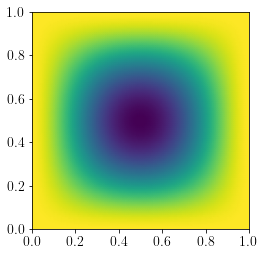

Reissner-Mindlin deflection: 1.381343203499173
Love-Kirchhoff deflection:   1.3817284430040004


In [1]:
from dolfin import *
import matplotlib.pyplot as plt

# material parameters
thick = Constant(1e-3)
E = Constant(10)
nu = Constant(0.3)

# bending stiffness
D = E*thick**3/(1-nu**2)/12.
# shear stiffness
F = E/2/(1+nu)*thick*5./6.

# uniform transversal load
f = Constant(-1e3*thick**3)

# Useful function for defining strain energy
def strain2voigt(eps):
    return as_vector([eps[0, 0], eps[1, 1], 2*eps[0, 1]])
def voigt2stress(S):
    return as_tensor([[S[0], S[2]], [S[2], S[1]]])
def curv(u):
    (w, theta) = split(u)
    return sym(grad(theta))
def shear_strain(u):
    (w, theta) = split(u)
    return theta-grad(w)
def bending_moment(u):
    DD = as_tensor([[D, nu*D, 0], [nu*D, D, 0],[0, 0, D*(1-nu)/2.]])
    return voigt2stress(dot(DD,strain2voigt(curv(u))))
def shear_force(u):
    return F*shear_strain(u)


# Unit square mesh NxN elements
N = 100
mesh = UnitSquareMesh(N, N, "crossed")

# Definition of function space for U:displacement, T:rotation
Ue = FiniteElement("Lagrange", mesh.ufl_cell(), 2)
Te = VectorElement("CR", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, MixedElement([Ue, Te]))

# Definition of boundary conditions
def border(x, on_boundary):
    return on_boundary
bc =  [DirichletBC(V,Constant((0.,)*3), border)]


# Functions
u = Function(V)
(w,theta) = split(u)
u_ = TestFunction(V)
du = TrialFunction(V)

# Linear and bilinear forms
L = f*u_[0]*dx
a = inner(bending_moment(u_),curv(du))*dx + dot(shear_force(u_),shear_strain(du))*dx

# Solver
solve(a == L, u, bc, solver_parameters={"linear_solver":"mumps"})

# Post-process
#(w,theta) = split(u)
w,theta = u.split(deepcopy=True)
plot(w, mode="color")
plt.show()

w_LK = 1.265319087e-3*float(-f/D)
print("Reissner-Mindlin deflection:", -w(0.5, 0.5))
print("Love-Kirchhoff deflection:  ", w_LK)

## Convergence results

We compare the convergence behaviour of the `P2/CR` vs a standard `P2/P1` discretization, on either a `"crossed"` or a `"left"` mesh.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


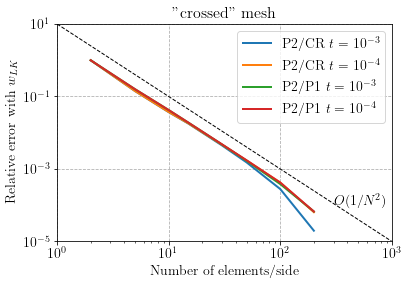

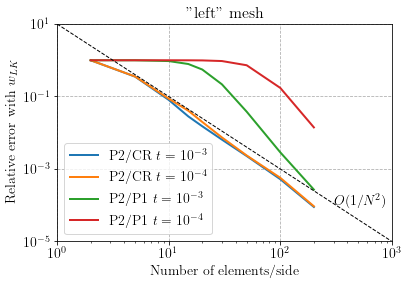

In [2]:
import numpy as np

labels = [r"P2/CR $t=10^{-3}$", r"P2/CR $t=10^{-4}$",
          r"P2/P1 $t=10^{-3}$", r"P2/P1 $t=10^{-4}$"]
for mesh_type in ["crossed", "left"]:
    data = np.loadtxt("reissner_mindlin_CR_{}.csv".format(mesh_type),
                      delimiter=",", skiprows=1)
    N = data[:, 0]
    res = np.abs(data[:, 1:]/w_LK-1)
    for (i, label) in enumerate(labels):
        plt.loglog(N, res[:, i], label=label)
    plt.loglog([1, 1e3], [1e1, 1e-5], "--k", linewidth=1)
    plt.annotate("$O(1/N^2$)", xy=[3e2, 1e-4], fontsize=14)
    plt.legend()
    plt.ylim(1e-5, 1e1)
    plt.title("\"{}\" mesh".format(mesh_type), fontsize=16)
    plt.xlabel("Number of elements/side")
    plt.ylabel("Relative error with $w_{LK}$")
    plt.show()

As expected, the `P2/P1` discretization locks in the thin plate limit for the `"left"`, whereas locking does not appear for the `"crossed"` mesh. On the contrary the `P2/CR` discretization does not lock and exhibits the same quadratic convergence for both types of mesh.

## References

[ARN89] Arnold, D. N., & Falk, R. S. (1989). A uniformly accurate finite element method for the Reissner–Mindlin plate. SIAM Journal on Numerical Analysis, 26(6), 1276-1290.

[CAM03] Campello, E. M. B., Pimenta, P. M., & Wriggers, P. (2003). A triangular finite shell element based on a fully nonlinear shell formulation. Computational Mechanics, 31(6), 505-518.